# **ENV Setup**


In [ ]:
!rm -rf *
!pip uninstall scikit-learn -y --quiet
!pip install -U scikit-learn --quiet
!pip install git+https://github.com/scikit-learn-contrib/imbalanced-learn.git@master > /dev/null 2>&1

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.3/13.3 MB 21.8 MB/s eta 0:00:00


# **Imports**

In [ ]:
import pandas as pd
import requests
import math
import random
import numpy as np
import json
import pickle


from os import path,getcwd,makedirs

# SKLearn Imports
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, PolynomialFeatures,RobustScaler

# Imbalanced Learn
from imblearn.over_sampling import *


import matplotlib.pyplot as plt
import seaborn as sns

# **Constants**

In [ ]:
# File Constants
CSV_URL = "https://res.cloudinary.com/ddfaksud1/raw/upload/v1716812163/Final%20Year%20Project/heart.csv"
LOCAL_CSV_NAME = "heart.csv"

# Training - Testing Constants
TEST_SIZE = 0.2

# Data Transormation Constants
OVERSAMPLING_STRATEGY = "minority"
OVERSAMPLING_RANDOM_STATE = random.randint(1,100)

# Model Constants
SVM_KERNEL = "linear"
SVM_RANDOM_STATE = 0
LOGISTIC_REGRESSION_RANDOM_STATE = 0
KNN_NUM_NEIGHBOURS = 5
KNN_METRIC = "minkowski"
KNN_POWER_PARAMETER = 2

# **Presets**

In [ ]:
model_summary = {}
logs = {}

# **Download CSV File**

In [ ]:
def download_csv_file():
  with requests.get(CSV_URL, stream=True) as response:
    with open(LOCAL_CSV_NAME, 'wb') as file:
            for chunk in response.iter_content(chunk_size=8192):
                file.write(chunk)

download_csv_file()

# **Local Setup**

In [ ]:
makedirs("BackendAssets",exist_ok=True)
makedirs("BackendAssets/Models",exist_ok=True)
makedirs("BackendAssets/DataInsights",exist_ok=True)

# **Reading the CSV**

In [ ]:
df = pd.read_csv(LOCAL_CSV_NAME).sample(frac=1)
df.head(1)

,HeartDisease,BMICategory,Smoking,AlcoholDrinking,Stroke,PhysicalHealth,MentalHealth,DiffWalking,Sex,AgeCategory,Race,Diabetic,PhysicalActivity,GenHealth,SleepTime,Asthma,KidneyDisease,SkinCancer
36578,0,3,1,1,1,0,0,0,1,5,5,1,1,1,7,0,0,0


# **Correlation Matrix**

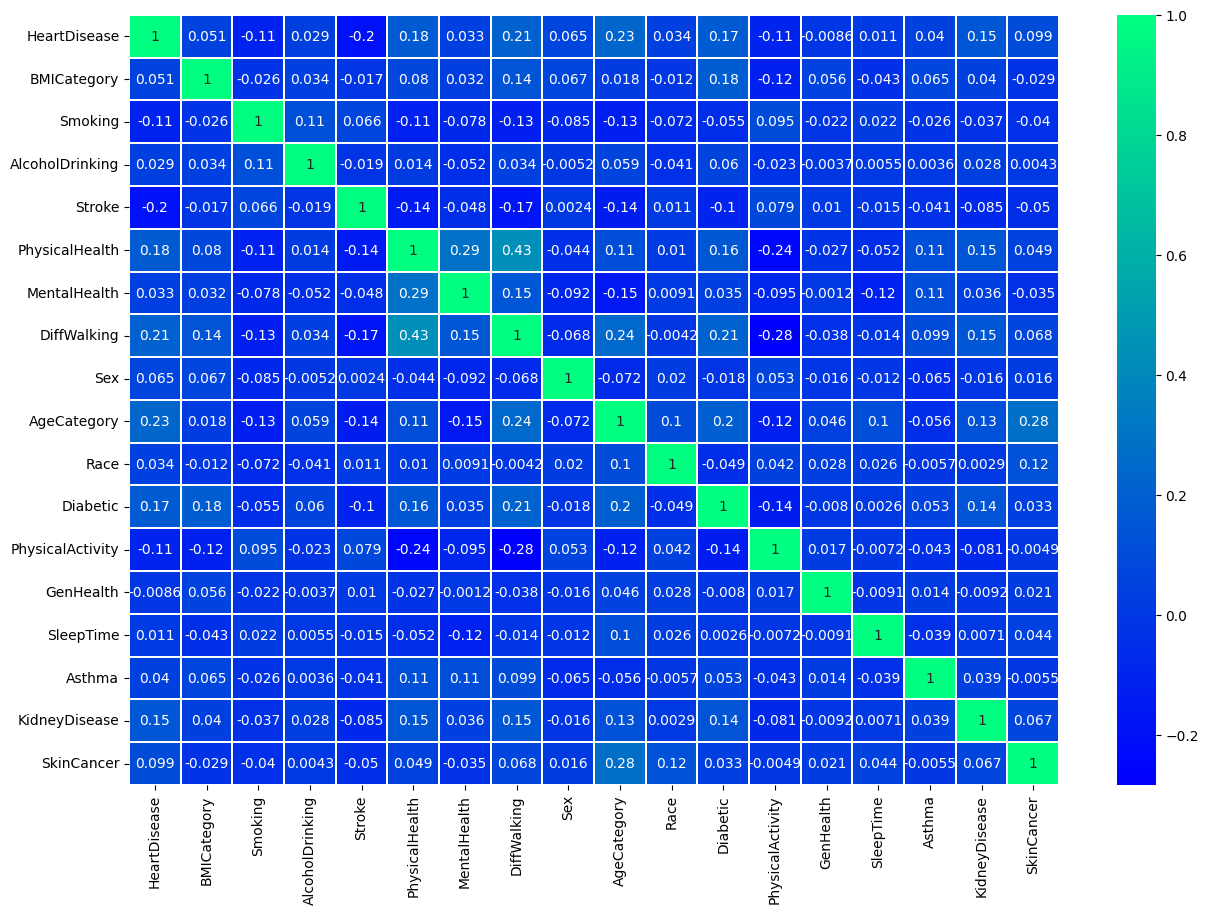

In [ ]:
plt.figure(figsize=(15,10))
sns.heatmap(df.corr(),linewidth=.01,annot=True,cmap="winter")
plt.savefig("BackendAssets/DataInsights/CorrelationMatrix.png")
plt.show()

# **Train-Test Split + Oversampling**

In [ ]:
# Extracting the Dependent and Independent features
X = df.drop(columns="HeartDisease", axis=1)
Y = df["HeartDisease"]

# Scaling the Data
scaler = StandardScaler()
scaler.fit(X)
X = scaler.transform(X)

# Train-Test Split
x_train, x_test,y_train, y_test = train_test_split(
  X, Y, test_size=TEST_SIZE, stratify=Y
)

# Oversampling
ros = SMOTE(sampling_strategy=OVERSAMPLING_STRATEGY,random_state=OVERSAMPLING_RANDOM_STATE)
x_train,y_train = ros.fit_resample(x_train,y_train)

# **Model Class**

In [ ]:
class ClassifierModel:
  def __init__(self,model,name):
    self.model_instance = model
    self.model_name = name
    self.prepare_model()
    self.calculate_metrics()
    self.log_model_insights()
    self.save_model()

  def prepare_model(self):
    self.model_instance.fit(x_train,np.ravel(y_train))
    self.y_pred = self.model_instance.predict(x_test)



  def calculate_metrics(self):
    self.accuracy = metrics.accuracy_score(y_test,self.y_pred) * 100
    self.confusion_matrix = metrics.confusion_matrix(y_test,self.y_pred)


  def log_model_insights(self):
    model_summary[self.model_name] = {
      "model": self.model_instance,
      "accuracy":self.accuracy,
      "confusion_matrix":self.confusion_matrix.tolist()
    }

  def save_model(self):
    with open(f'BackendAssets/Models/{self.model_name.replace(" ","_")}.pkl',"wb") as file:
      pickle.dump(self.model_instance,file)

# **Models**

In [ ]:
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier

# svm_model = ClassifierModel(model = SVC(kernel=SVM_KERNEL,random_state=SVM_RANDOM_STATE),name = "SVM")
lr_model = ClassifierModel(model = LogisticRegression(random_state=LOGISTIC_REGRESSION_RANDOM_STATE),name = "Logistic Regression")
rfc_model = ClassifierModel(model = RandomForestClassifier(),name = "Random Forest")
gnb_model = ClassifierModel(model = GaussianNB(),name = "Gaussian Naive Bayes")
knn_model = ClassifierModel(model = KNeighborsClassifier(n_neighbors=KNN_NUM_NEIGHBOURS,metric=KNN_METRIC,p=KNN_POWER_PARAMETER),name = "KNN")
dt_model = ClassifierModel(model = DecisionTreeClassifier(),name = "Decision Tree")

In [ ]:
model_summary

{'Logistic Regression': {'model': LogisticRegression(random_state=0),
  'accuracy': 74.52964340406913,
  'confusion_matrix': [[12468, 4253], [404, 1159]]},
 'Random Forest': {'model': RandomForestClassifier(),
  'accuracy': 89.83810982279589,
  'confusion_matrix': [[16137, 584], [1274, 289]]},
 'Gaussian Naive Bayes': {'model': GaussianNB(),
  'accuracy': 80.14657624152264,
  'confusion_matrix': [[13709, 3012], [618, 945]]},
 'KNN': {'model': KNeighborsClassifier(),
  'accuracy': 79.50667250054693,
  'confusion_matrix': [[13778, 2943], [804, 759]]},
 'Decision Tree': {'model': DecisionTreeClassifier(),
  'accuracy': 86.60030627871363,
  'confusion_matrix': [[15461, 1260], [1190, 373]]}}

# **Logging**

In [ ]:
# Logging the Basic Insights of the whole Training Process

logs["Test_size"] = 0.2
logs["Oversampling_strategy"] = OVERSAMPLING_STRATEGY
logs["Oversampling_random_state"] = OVERSAMPLING_RANDOM_STATE

logs["SVM"] = {}
logs["SVM"]["Kernel"] = SVM_KERNEL
logs["SVM"]["Random_State"] = SVM_RANDOM_STATE

logs["Logistic Regression"] = {}
logs["Logistic Regression"]["Random_State"] = LOGISTIC_REGRESSION_RANDOM_STATE

logs["KNN"] = {}
logs["KNN"]["Num_Neighbours"] = KNN_NUM_NEIGHBOURS
logs["KNN"]["Metric"] = KNN_METRIC
logs["KNN"]["Power_Parameter"] = KNN_POWER_PARAMETER

# **Testing the Category Based Accuracy**

In [ ]:
def test_category_based_accuracy_of_model(category,model):
  cnt = 0
  filtered_test_set = x_test[y_test == category]
  for test_set in filtered_test_set:
    if int(model.predict([test_set])[0]) == category:
      cnt += 1
  return (cnt/len(filtered_test_set)) * 100

In [ ]:
models = list(model_summary.keys())

for model in models:
  zero_acc = test_category_based_accuracy_of_model(0,model_summary[model]["model"])
  one_acc = test_category_based_accuracy_of_model(1,model_summary[model]["model"])

  model_summary[model]["0_accuracy"] = zero_acc
  model_summary[model]["1_accuracy"] = one_acc

print(model_summary)


{'SVM': {'model': SVC(kernel='linear', random_state=0), 'accuracy': 72.71384817326624, 'confusion_matrix': [[12043, 4678], [311, 1252]], '0_accuracy': 72.02320435380659, '1_accuracy': 80.10236724248242}, 'Logistic Regression': {'model': LogisticRegression(random_state=0), 'accuracy': 74.69919054911398, 'confusion_matrix': [[12442, 4279], [347, 1216]], '0_accuracy': 74.40942527360804, '1_accuracy': 77.79910428662828}, 'Random Forest': {'model': RandomForestClassifier(), 'accuracy': 89.44979216801575, 'confusion_matrix': [[16051, 670], [1259, 304]], '0_accuracy': 95.99306261587226, '1_accuracy': 19.44977607165707}, 'Gaussian Naive Bayes': {'model': GaussianNB(), 'accuracy': 80.34893896302778, 'confusion_matrix': [[13732, 2989], [604, 959]], '0_accuracy': 82.12427486394354, '1_accuracy': 61.35636596289188}, 'KNN': {'model': KNeighborsClassifier(), 'accuracy': 79.35353314373222, 'confusion_matrix': [[13691, 3030], [745, 818]], '0_accuracy': 81.86113270737397, '1_accuracy': 52.2712731925783

# **Dumping all the Insights**

In [ ]:
with open("BackendAssets/logs.json",'w') as fp:
  fp.write(json.dumps(logs))

with open("BackendAssets/models.json",'w') as fp:
  model_summary_writable = {}
  models = list(model_summary.keys())
  for model in models:
    model_summary_writable[model] = {
        "accuracy":model_summary[model]["accuracy"],
        "confusion_matrix":model_summary[model]["confusion_matrix"],
        '0_accuracy' : model_summary[model]["0_accuracy"],
        '1_accuracy' : model_summary[model]["1_accuracy"]
    }

  fp.write(json.dumps(model_summary_writable))

FileNotFoundError: [Errno 2] No such file or directory: 'BackendAssets/logs.json'